   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Crea

100%|██████████| 21.5M/21.5M [00:00<00:00, 162MB/s]



0: 448x640 3 persons, 1 traffic light, 820.0ms
Speed: 20.9ms preprocess, 820.0ms inference, 34.0ms postprocess per image at shape (1, 3, 448, 640)


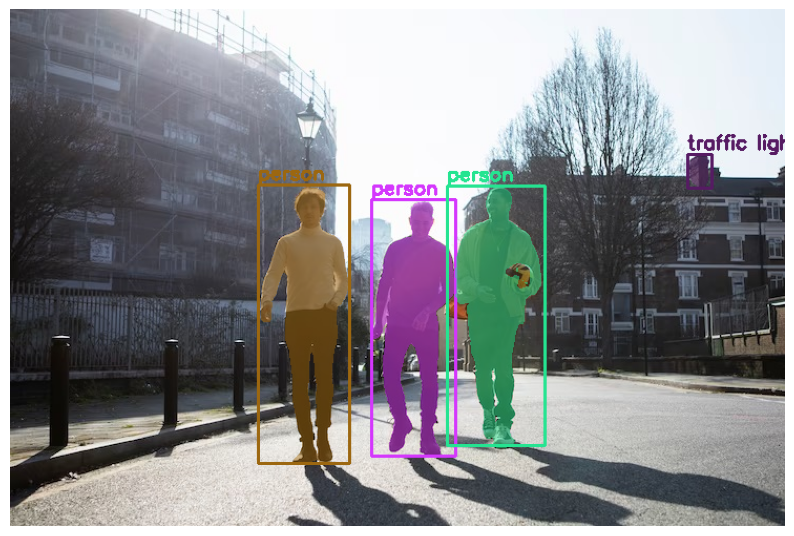

           Clase   Area
0         person  11181
1         person  10377
2         person  10825
3  traffic light    496

0: 640x640 1 banana, 4 oranges, 570.1ms
Speed: 7.4ms preprocess, 570.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


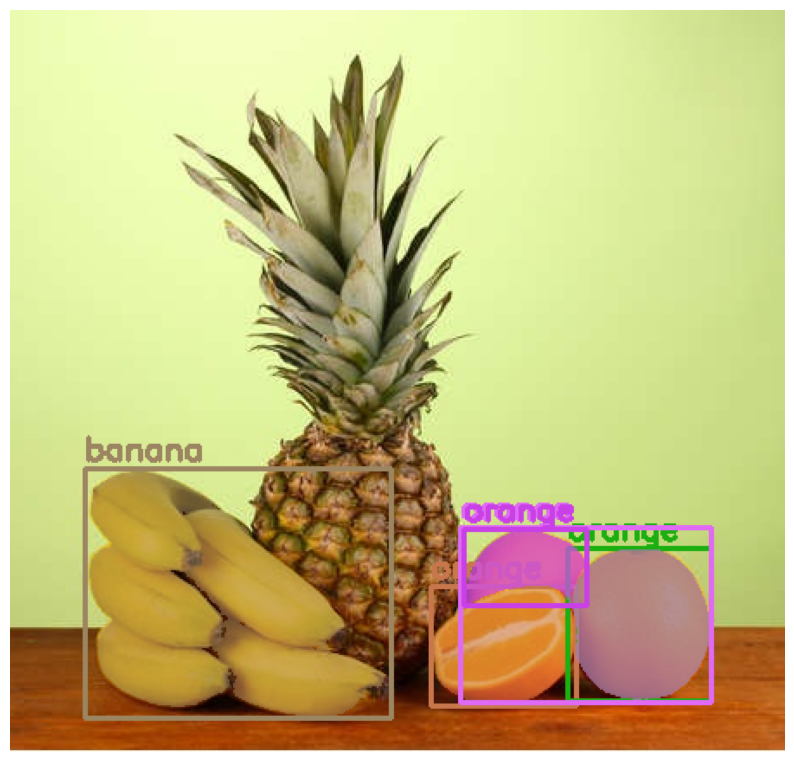

    Clase   Area
0  banana  14917
1  orange   4363
2  orange   5610
3  orange   7539
4  orange   1918

0: 384x640 1 cat, 1 dog, 410.7ms
Speed: 8.4ms preprocess, 410.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


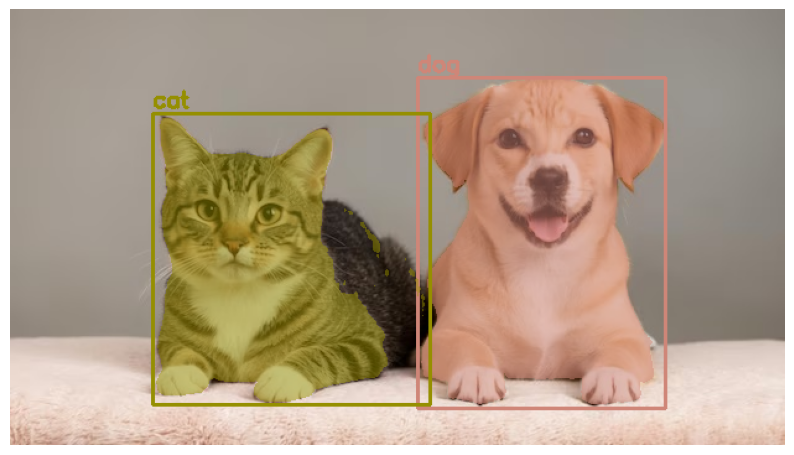

  Clase   Area
0   dog  38922
1   cat  29603


In [3]:
!pip install ultralytics supervision opencv-python matplotlib segment-anything -q
!pip install git+https://github.com/facebookresearch/segment-anything.git -q

import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
from torchvision.transforms.functional import to_pil_image

os.makedirs("outputs/recortes", exist_ok=True)
os.makedirs("outputs/segmentaciones", exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO("yolov8s.pt")
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth").to(device)
predictor = SamPredictor(sam)

def detectar_objetos_yolo(imagen_path):
    imagen = cv2.imread(imagen_path)
    resultados = yolo_model(imagen)[0]
    boxes = []
    clases = []
    for r in resultados.boxes.data:
        x1, y1, x2, y2, conf, cls = r.cpu().numpy()
        boxes.append([int(x1), int(y1), int(x2), int(y2)])
        clases.append(int(cls))
    return imagen, boxes, clases

def segmentar_con_sam(imagen, boxes):
    predictor.set_image(imagen)
    masks = []
    for box in boxes:
        box_np = np.array(box)[None, :]
        mask, _, _ = predictor.predict(box=box_np, multimask_output=False)
        masks.append(mask[0])
    return masks

def visualizar_deteccion_segmentacion(imagen, boxes, masks, clases, nombres, nombre_archivo):
    imagen_dibujada = imagen.copy()
    for box, mask, clase in zip(boxes, masks, clases):
        color = np.random.randint(0, 255, 3).tolist()
        x1, y1, x2, y2 = box
        cv2.rectangle(imagen_dibujada, (x1, y1), (x2, y2), color, 2)
        cv2.putText(imagen_dibujada, nombres[clase], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        imagen_dibujada[mask] = imagen_dibujada[mask] * 0.5 + np.array(color) * 0.5
        objeto = np.ones_like(imagen) * 255
        for c in range(3):
            objeto[:, :, c] = imagen[:, :, c] * mask
        recorte = objeto[y1:y2, x1:x2]
        cv2.imwrite(f"outputs/recortes/{nombres[clase]}_{x1}_{y1}.png", recorte)
        cv2.imwrite(f"outputs/segmentaciones/{nombres[clase]}_{x1}_{y1}_mask.png", (mask * 255).astype(np.uint8))
    cv2.imwrite(f"outputs/{nombre_archivo}_resultado.png", imagen_dibujada)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(imagen_dibujada, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

def analizar_segmentaciones(masks, clases, nombres):
    datos = []
    for mask, clase in zip(masks, clases):
        area = np.sum(mask)
        datos.append((nombres[clase], area))
    import pandas as pd
    df = pd.DataFrame(datos, columns=["Clase", "Area"])
    df.to_csv("outputs/segmentacion_analisis.csv", index=False)
    print(df)

nombres = yolo_model.model.names

for nombre in ["personas", "frutas", "mascotas"]:
    imagen_path = f"{nombre}.jpg"
    imagen, boxes, clases = detectar_objetos_yolo(imagen_path)
    masks = segmentar_con_sam(imagen, boxes)
    visualizar_deteccion_segmentacion(imagen, boxes, masks, clases, nombres, nombre)
    analizar_segmentaciones(masks, clases, nombres)
